Imports

In [232]:
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Get the table

In [233]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(link)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Take out boroughs not assigned and replace not assigned neighbourhoods

In [234]:
df.drop(df[df.Borough == "Not assigned"].index, inplace=True)
df.Neighbourhood.replace("Not assigned", df.Borough, inplace=True)
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)
df.head()

#df.reset_index(inplace=True)
#df.drop("index", axis=1, inplace=True)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Join repeated postcodes

In [235]:
groups_postcodes = df.groupby("Postcode")
#groups_postcodes.groups

In [236]:
#inds = groups_postcodes.get_group("M5A")["Neighbourhood"].index
#a = df.iloc[inds].Neighbourhood
for key in groups_postcodes.groups.keys():
    inds = groups_postcodes.get_group(key)["Neighbourhood"].index
    serie = df.iloc[inds].Neighbourhood
    #print(serie)
    string = serie.str.cat(sep=", ")
    #print(string)
    df.iloc[inds, 2] = string

# drop_duplicates
df.drop_duplicates(subset="Postcode", keep='first', inplace=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M7A,Queen's Park,Queen's Park


In [237]:
print("This table has " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")

This table has 103 rows and 3 columns


Get the coordinates

In [238]:
url = "http://cocl.us/Geospatial_data"
df2 = pd.read_csv(url,sep=",")
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


If sorted the postal codes should be on the same order

In [239]:
df.sort_values("Postcode", inplace=True)
df2.sort_values("Postal Code", inplace=True)
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)
df2.reset_index(inplace=True)
df2.drop("index", axis=1, inplace=True)
df["Postcode"].equals(df2["Postal Code"])

True

They are in the same order

In [240]:
df["Latitude"] = df2["Latitude"]
df["Longitude"] = df2["Longitude"]

df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Get coordinates for map

In [241]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Take out the boroughs without the word toronto

In [242]:
df_map = df[df["Borough"].str.contains("Toronto", regex=False) == True]
df_map.reset_index(drop=True, inplace=True)
df_map.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Create a map of toronto

In [243]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_map['Latitude'], df_map['Longitude'], df_map['Borough'], df_map['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Foursquare credentials

In [244]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [245]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        print(len(results), name)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I am just gonna get the top 80 venues in a 300 radius of my neighbourhoods

In [246]:
toronto_venues = getNearbyVenues(names=df_map['Neighbourhood'],
                                   latitudes=df_map['Latitude'],
                                   longitudes=df_map['Longitude'],
                                   radius = 300,
                                   LIMIT = 80
                                  )
toronto_venues.head()

4 The Beaches
24 The Danforth West, Riverdale
16 The Beaches West, India Bazaar
26 Studio District
3 Lawrence Park
4 Davisville North
1 North Toronto West
22 Davisville
2 Moore Park, Summerhill East
5 Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
2 Rosedale
22 Cabbagetown, St. James Town
52 Church and Wellesley
14 Harbourfront, Regent Park
64 Ryerson, Garden District
42 St. James Town
7 Berczy Park
32 Central Bay Street
60 Adelaide, King, Richmond
64 Harbourfront East, Toronto Islands, Union Station
73 Design Exchange, Toronto Dominion Centre
79 Commerce Court, Victoria Hotel
1 Roselawn
0 Forest Hill North, Forest Hill West
13 The Annex, North Midtown, Yorkville
22 Harbord, University of Toronto
68 Chinatown, Grange Park, Kensington Market
4 CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
43 Stn A PO Boxes 25 The Esplanade
73 First Canadian Place, Underground city
7 Christie
11 Dovercourt Village, Dufferin
3

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
1,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
2,The Beaches,43.676357,-79.293031,Balmy Beach Playground,43.676078,-79.290805,Playground
3,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Let's check some information about the venues found in each neighbourhood (how many in total, per neighbourhood, and unique ones)

In [247]:
print("There are {} venues in the neighbourhoods of Toronto.".format(str(toronto_venues.shape[0])))
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

toronto_venues.groupby('Neighbourhood').count()

There are 944 venues in the neighbourhoods of Toronto.
There are 182 uniques categories.


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",60,60,60,60,60,60
Berczy Park,7,7,7,7,7,7
"Brockton, Exhibition Place, Parkdale Village",15,15,15,15,15,15
Business Reply Mail Processing Centre 969 Eastern,7,7,7,7,7,7
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",4,4,4,4,4,4
"Cabbagetown, St. James Town",22,22,22,22,22,22
Central Bay Street,32,32,32,32,32,32
"Chinatown, Grange Park, Kensington Market",68,68,68,68,68,68
Christie,7,7,7,7,7,7


Lets use dummies to better understand the venue categories

In [248]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [249]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.shape

(36, 183)

Something is wrong. df_map had 38 rows and toronto_grouped has 36 rows. Two neighbourhoods may not have any venues in the Foursquare API.

In [250]:
missing = set(df_map["Neighbourhood"]).difference(set(toronto_venues.groupby('Neighbourhood').groups.keys()))

print("The neighbourhoods " + str(missing) + " have no venues. They will be eliminated from df_map.")
i1 = df_map[df_map["Neighbourhood"] == list(missing)[0]].index
i2 = df_map[df_map["Neighbourhood"] == list(missing)[1]].index

df_map.drop(i1, axis=0, inplace=True)
df_map.drop(i2, axis=0, inplace=True)

df_map.shape

The neighbourhoods {'High Park, The Junction South', 'Forest Hill North, Forest Hill West'} have no venues. They will be eliminated from df_map.


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(36, 5)

Lets find the 5 most common venues for each neighbourhood

In [251]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [252]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Coffee Shop,American Restaurant,Asian Restaurant,Bar
1,Berczy Park,Italian Restaurant,Beer Bar,Liquor Store,Concert Hall,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Café,Sandwich Place,Coffee Shop,Japanese Restaurant,Breakfast Spot
3,Business Reply Mail Processing Centre 969 Eastern,Brewery,Garden,Park,Light Rail Station,Fast Food Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,Yoga Studio


Get shape

In [253]:
print(neighbourhoods_venues_sorted.shape)
print(toronto_grouped.shape)

(36, 6)
(36, 183)


Run k-means for 3 clusters

In [254]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

I will use the elbow method to choose a k

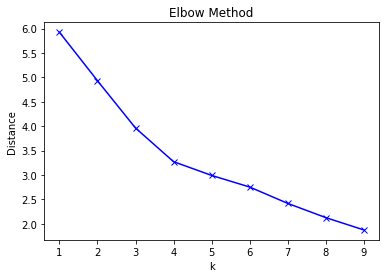

In [255]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

inertia = []
kclusters = range(1,10)
X = toronto_grouped_clustering
for k in kclusters:
    kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(kclusters, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('Elbow Method')
plt.show()

I am gonna choose k=4

In [256]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 3, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [257]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_map

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!
#neighbourhoods_venues_sorted.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Park,Other Great Outdoors,Playground,Trail,Discount Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Ice Cream Shop,Yoga Studio,Italian Restaurant,Cosmetics Shop
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Pub,Ice Cream Shop,Liquor Store,Burrito Place,Burger Joint
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Café,Italian Restaurant,New American Restaurant,Bar
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Photography Studio,Lake,Jewelry Store,Flower Shop,Fish & Chips Shop


Lets look at the clusters

In [258]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I do not think that kmeans is the best approach, but lets look at the clusters

## Let's examine the clusters

#### Cluster 1

In [259]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Central Toronto,0,Park,Beer Store,Yoga Studio,Dive Bar,Fish & Chips Shop
10,Downtown Toronto,0,Building,Park,Yoga Studio,Dive Bar,Fish & Chips Shop


#### Cluster 2

In [260]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,1,Park,Other Great Outdoors,Playground,Trail,Discount Store
1,East Toronto,1,Greek Restaurant,Ice Cream Shop,Yoga Studio,Italian Restaurant,Cosmetics Shop
2,East Toronto,1,Pub,Ice Cream Shop,Liquor Store,Burrito Place,Burger Joint
3,East Toronto,1,Coffee Shop,Café,Italian Restaurant,New American Restaurant,Bar
4,Central Toronto,1,Photography Studio,Lake,Jewelry Store,Flower Shop,Fish & Chips Shop
5,Central Toronto,1,Breakfast Spot,Gym,Grocery Store,Pool,Yoga Studio
7,Central Toronto,1,Dessert Shop,Café,Italian Restaurant,Coffee Shop,Pizza Place
9,Central Toronto,1,Coffee Shop,Park,Convenience Store,Supermarket,Dive Bar
11,Downtown Toronto,1,Café,Coffee Shop,Restaurant,Pizza Place,Gym / Fitness Center
12,Downtown Toronto,1,Gay Bar,Burger Joint,Japanese Restaurant,Coffee Shop,Yoga Studio


#### Cluster 3

In [261]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Central Toronto,2,Health & Beauty Service,Yoga Studio,Dive Bar,Fish Market,Fish & Chips Shop


#### Cluster 4

In [262]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Central Toronto,3,Sushi Restaurant,Yoga Studio,Dive Bar,Fish & Chips Shop,Fast Food Restaurant


I do not think we can make many assumptions based on this data.